In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import os

In [2]:
from constants import meta_cols, norm_bounds, type_dict, pu_cols, peou_cols, se_cols, load_cols

Define a few helper functions. These are to easily extract construct specific columns from a data frame passed as argument.

In [3]:
def get_construct_df(df: pd.DataFrame, construct_cols: list[str]) -> pd.DataFrame:
    return df[construct_cols]

### Data Preparation

Read the initial raw data and fix scale for the single question that was asked with an inverted scale due to limitations with LimeSurvey ("Performance" of the NASA TLX questionnaire).

In [4]:
raw_res = pd.read_csv("./data/survey_results.csv", index_col="id", dtype=type_dict, parse_dates=["submitdate", "startdate", "datestamp"], date_format="%Y-%m-%dT%H:%M:%S%z")

# fix scale for load question 4 (needs to be reversed)
raw_res["load[SQ004]"] = 20 - raw_res["load[SQ004]"]

Remove some metadata columns that LimeSurvey adds automatically, but are not needed for the evaluation. Additionally the metadata (see `meta_cols` for more information) will be separated into its own data frame for easier data handling.

In [5]:
working_df = raw_res.drop(columns=["lastpage", "startlanguage", "gender_other", "seed", "token", "refurl"])

meta_df = working_df[meta_cols]
data_df = working_df.drop(columns=meta_cols)

# sanity check df format
data_df

,group,usefulness[SQ001],usefulness[SQ002],usefulness[SQ003],usefulness[SQ004],usefulness[SQ005],usefulness[SQ006],ease_of_use[SQ001],ease_of_use[SQ002],ease_of_use[SQ003],...,self_efficacy[SQ007],self_efficacy[SQ008],self_efficacy[SQ009],self_efficacy[SQ010],load[SQ001],load[SQ002],load[SQ003],load[SQ004],load[SQ005],load[SQ006]
id,,,,,,,,,,,,,,,,,,,,,
1,E,7,5,6,6,6,7,7,7,7,...,3,1,8,9,10,1,3,5,10,4
2,B,2,2,7,7,7,7,7,3,7,...,9,9,9,9,3,8,0,14,12,12
3,B,7,2,4,4,4,4,7,6,6,...,9,9,9,10,18,8,0,1,15,15
4,E,7,7,7,7,7,7,7,6,7,...,10,9,10,10,2,0,0,2,0,0
5,B,6,5,5,5,6,6,7,7,7,...,10,10,10,10,13,2,6,2,15,15
7,E,4,4,6,6,6,6,7,4,4,...,2,9,10,2,4,0,0,4,0,0
8,E,5,2,6,4,6,6,7,6,6,...,10,7,10,10,18,2,0,1,17,1
9,E,7,5,6,6,7,6,7,7,7,...,10,9,10,10,13,0,0,7,13,1
10,E,5,6,4,6,5,6,5,4,5,...,5,6,5,6,10,0,14,7,8,9


**Start cleanup based on the final cell from here. This will require some reorganization of the cells and analysis steps.**

### Data Analysis

The analysis is performed using simple comparisons of the different groups. It will be split between the different questionnaires used in the study (TAM, Self-Efficacy, NASA TLX), where TAM is split into its two subscales (Perceived Usefulness and Perceived Ease of Use), CSE is evaluated as a whole, and NASA TLX is evaluated for four of its six subscales (Mental Demand, Performance, Effort, Frustration) aligned with the "raw TLX" evaluation [often used](https://doi.org/10.1177/154193120605000909). Since the given task was not time-constrained and did not involve physical effort, the corresponding subscales are ignored in the evaluation.

The following steps are performed as part of the analysis:

1. Slice the relevant columns from the main data frame for each construct
2. Perform any necessary combination of columns to create overall scores for the constructs for each participant (row)
3. Store a main result CSV for all participants and constructs (`./out/study_results.csv`) and a normalised version (`./out/study_results_normalised.csv`)
4. Compare the different groups (baseline vs. explanation) for each construct using statistical tests
5. Store the results of the statistical tests in a CSV file (`./out/statistical_evaluation.csv`)

#### Slice Data into Construct Data Frames

Slice the main data frame into separate data frames for each construct using the helper function defined above. For NASA TLX, drop the two columns that are not used in the analysis (Physical Demand and Temporal Demand).

In [6]:
pu_df = get_construct_df(data_df, pu_cols)
peou_df = get_construct_df(data_df, peou_cols)
se_df = get_construct_df(data_df, se_cols)
load_df = get_construct_df(data_df, load_cols).drop(columns=["load[SQ002]", "load[SQ003]"])

#### Calculate Construct Scores

Calculate the overall scores for each construct by taking the mean of the relevant columns for each participant (row). This means avaeraging the resopnses to the individual questions that make up each construct for Perceived Usefulness, Perceived Ease of Use, and Computer Self-Efficacy. NASA TLX is already a single score per subscale, so no further calculation is needed.

In [7]:
pu_scores = pu_df.mean(axis=1)
peou_scores = peou_df.mean(axis=1)
se_scores = se_df.mean(axis=1)

In [8]:
results_df = pd.DataFrame({
    "UUID": meta_df["UUID"],
    "Group": data_df["group"],
    "Perceived Usefulness": pu_scores,
    "Perceived Ease of Use": peou_scores,
    "Self-Efficacy": se_scores,
    "Mental Load": load_df["load[SQ001]"],
    "Performance": load_df["load[SQ004]"],
    "Effort": load_df["load[SQ005]"],
    "Frustration": load_df["load[SQ006]"]
})

# Normalise each column to [0, 1] using the bounds in a new df
norm_results_df = results_df.copy()
for col, (low, high) in norm_bounds.items():
    norm_results_df[col] = (results_df[col] - low) / (high - low)

results_df.to_csv("./out/study_results.csv", index=False)
norm_results_df.to_csv("./out/study_results_normalised.csv", index=False)

norm_results_df[["UUID", "Group", "Perceived Usefulness", "Frustration"]]

,UUID,Group,Perceived Usefulness,Frustration
id,,,,
1,f971d5ae-a9ff-4a23-a92b-7650ad697dfc,E,0.861111,0.2
2,7d8c9331-dd8c-4df6-8f6c-9e7a16d008d9,B,0.722222,0.6
3,fa69270e-20e0-4849-bae1-473de60495a4,B,0.527778,0.75
4,8d7e51b5-77bd-4474-8bcb-127fa69cd98c,E,1.0,0.0
5,f41a9ecb-7000-4ae1-8b8e-1b39ea598476,B,0.75,0.75
7,adbea003-c17e-463f-8ae0-c397f6f3eec1,E,0.722222,0.0
8,74463bbb-d158-461a-82f3-a030a108e157,E,0.638889,0.05
9,c4806f2c-dd6d-425c-a23d-62d29b4a1e5b,E,0.861111,0.05
10,dbc1d144-1c2c-42f5-b63c-e84c446a9189,E,0.722222,0.45


### Statistical Evaluation

The validity of the statistical tests is validated using Mann-Whitney U tests and (Welch's) t-tests for all comparisons. since the small sample size does not allow for a reliable assessment (or assumption) of normality, the non-parametric Mann-Whitney U test is preferred. However, for completeness, t-tests are also reported.

Statistical tests are performed using the `scipy.stats` library.

In [9]:
stat_results = []

The constructs measured by TAM and CSE are using the same methodology and therefore the same code can be reused. The hypothesized direction of the effect is that the explanation group (E) will score higher than the baseline group (B) for all constructs. Following this hypothesis, the Mann-Whitney U test is performed with the alternative hypothesis that group B scores lower than group E (i.e., `alternative="less"`).

In [10]:
for const in ["Perceived Usefulness", "Perceived Ease of Use", "Self-Efficacy"]:
    b = results_df[results_df["Group"] == "B"][const]
    e = results_df[results_df["Group"] == "E"][const]

    u_res = stats.mannwhitneyu(b, e, alternative="less")
    u_pval = u_res.pvalue
    u_stat = u_res.statistic

    t_res = stats.ttest_ind(b, e, alternative="less", equal_var=False)
    t_pval = t_res.pvalue
    t_stat = t_res.statistic

    stat_results.append(
        {
            "const": const,
            "b_mean": b.mean(),
            "e_mean": e.mean(),
            "mannwhitneyu_stat": u_stat,
            "mannwhitneyu_p": u_pval,
            "ttest_stat": t_stat,
            "ttest_p": t_pval,
        }
    )

The constructs for NASA TLX are different form TAM and CSE, since higher scores indicate a higher workload. Therefore, the hypothesized direction of the effect is that group B will score lower than group E for all constructs. Following this hypothesis, the Mann-Whitney U test is performed with the alternative hypothesis that group B scores greater than group E (i.e., `alternative="greater"`).

In [11]:
for const in ["Mental Load", "Performance", "Effort", "Frustration"]:
    b = results_df[results_df["Group"] == "B"][const]
    e = results_df[results_df["Group"] == "E"][const]

    u_res = stats.mannwhitneyu(b, e, alternative="greater")
    u_pval = u_res.pvalue
    u_stat = u_res.statistic

    t_res = stats.ttest_ind(b, e, alternative="greater", equal_var=False)
    t_pval = t_res.pvalue
    t_stat = t_res.statistic

    stat_results.append(
        {
            "const": const,
            "b_mean": b.mean(),
            "e_mean": e.mean(),
            "mannwhitneyu_stat": u_stat,
            "mannwhitneyu_p": u_pval,
            "ttest_stat": t_stat,
            "ttest_p": t_pval,
        }
    )

In [12]:
stat_results_df = pd.DataFrame(stat_results)
stat_results_df = stat_results_df.rename(columns={
    "const": "Construct",
    "b_mean": "Base Mean",
    "e_mean": "Explanation Mean",
    "mannwhitneyu_stat": "Mann-Whitney U Stat",
    "mannwhitneyu_p": "Mann-Whitney U p-value",
    "ttest_stat": "t-test Stat",
    "ttest_p": "t-test p-value"
})

stat_results_df.to_csv("./out/statistical_evaluation.csv", index=False)

stat_results_df

,Construct,Base Mean,Explanation Mean,Mann-Whitney U Stat,Mann-Whitney U p-value,t-test Stat,t-test p-value
0,Perceived Usefulness,5.250000,5.904762,11.0,0.084082,-1.726694,0.056140
1,Perceived Ease of Use,6.166667,5.928571,24.0,0.693676,0.566684,0.707922
2,Self-Efficacy,9.350000,8.214286,26.0,0.785899,1.542875,0.915480
3,Mental Load,12.333333,10.714286,24.5,0.331933,0.506887,0.311120
4,Performance,7.000000,3.857143,27.0,0.213129,1.137086,0.147984
5,Effort,10.666667,9.428571,21.5,0.500000,0.381143,0.355670
6,Frustration,10.500000,2.571429,37.5,0.010499,2.917351,0.010525


### Visualisation

The results are visualised using box plots created with `matplotlib`. Several visualisation options are explored, to allow for the best represenation of the results:

1. Summary graphs for all constructs comparing the means of the two groups (baseline vs. explanation)
2. Individual graphs for each construct comparing the individual responses of the two groups (baseline vs. explanation)

In [13]:
constructs = [
    "Perceived Usefulness",
    # "Perceived Ease of Use",
    # "Self-Efficacy",
    # "Mental Load",
    # "Performance",
    # "Effort",
    "Frustration"
]
# Split constructs for dual y-axis
constructs_left = [
    "Perceived Usefulness",
    # "Perceived Ease of Use",
    # "Self-Efficacy"
]
constructs_right = [
    # "Mental Load",
    # "Performance",
    # "Effort",
    "Frustration"
]
group_colors = {"B": "tab:blue", "E": "tab:orange"}

os.makedirs("./out/images", exist_ok=True)

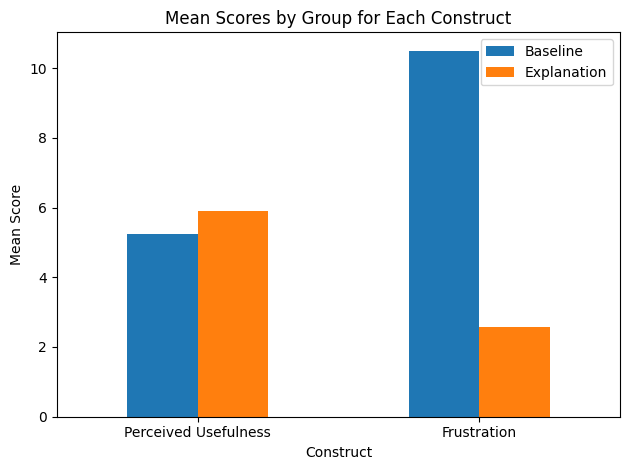

In [14]:
means_df = stat_results_df[stat_results_df["Construct"].isin(constructs)].set_index(
    "Construct"
)[["Base Mean", "Explanation Mean"]]

ax = means_df.plot(kind="bar")
ax.set_ylabel("Mean Score")
ax.set_title("Mean Scores by Group for Each Construct")
ax.legend(["Baseline", "Explanation"])
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(f"./out/images/mean_scores_by_group.png")
plt.show()

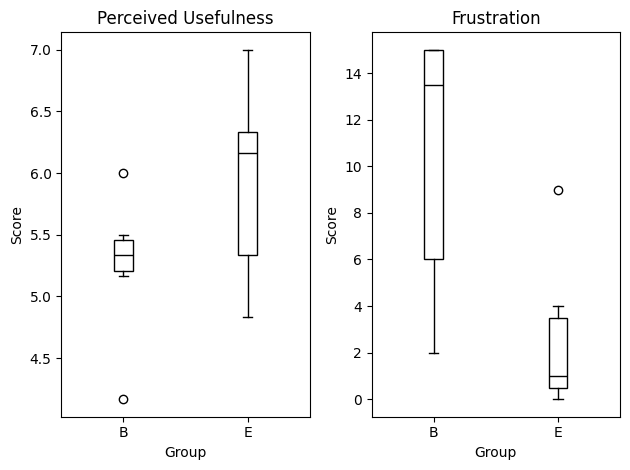

In [15]:
fig, axes = plt.subplots(1, len(constructs))

for i, const in enumerate(constructs):
    data = [results_df[results_df["Group"] == grp][const] for grp in group_colors]
    axes[i].boxplot(data, patch_artist=True,
                    boxprops=dict(facecolor='white'),
                    medianprops=dict(color='black'))
    axes[i].set_xticklabels(list(group_colors.keys()))
    axes[i].set_title(const)
    axes[i].set_xlabel("Group")
    axes[i].set_ylabel("Score")

plt.tight_layout()
plt.savefig("./out/images/boxplots_all_constructs.png")
plt.show()

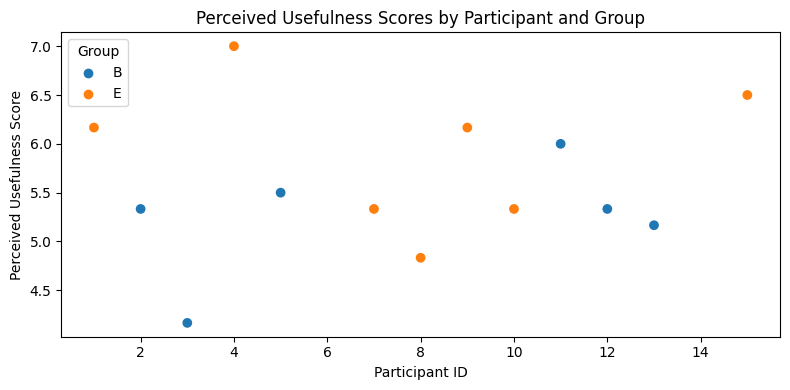

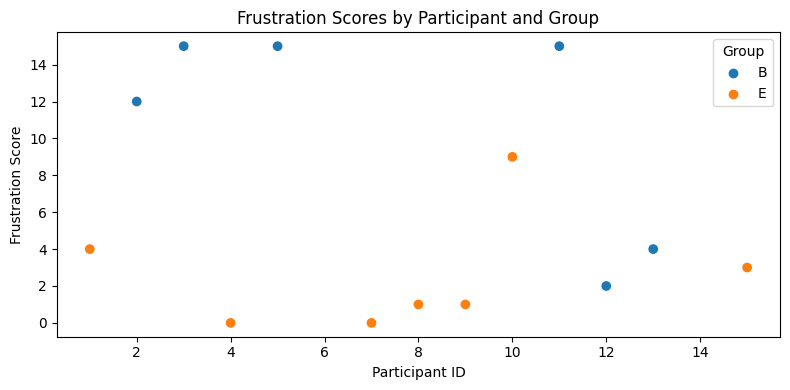

In [16]:
os.makedirs("./out/images/constructs", exist_ok=True)

for const in constructs:
    label = const.replace(" ", "_").lower()
    plt.figure(figsize=(8, 4))
    # Sort by group for consistent coloring
    df_sorted = results_df.sort_values("Group")
    plt.scatter(
        df_sorted.index,
        df_sorted[const],
        c=df_sorted["Group"].map(group_colors),
        label=None
    )
    for grp in group_colors:
        plt.scatter([], [], c=group_colors[grp], label=grp)
    plt.xlabel("Participant ID")
    plt.ylabel(f"{const} Score")
    plt.title(f"{const} Scores by Participant and Group")
    plt.legend(title="Group")
    plt.tight_layout()
    plt.savefig(f"./out/images/constructs/{label}_scores.png")
    plt.show()

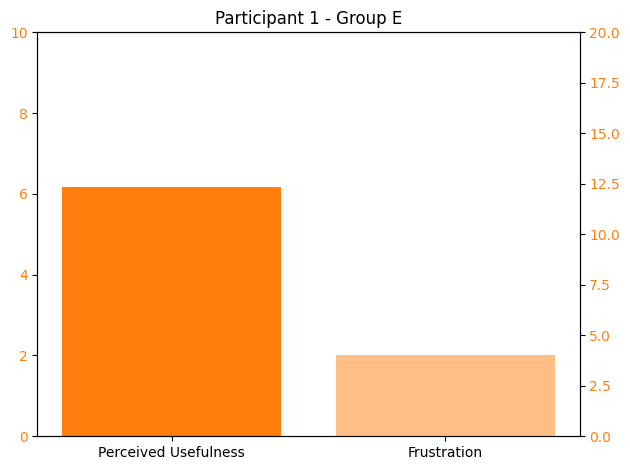

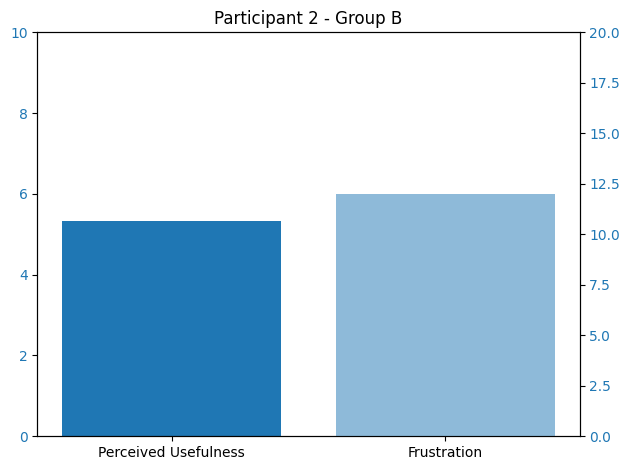

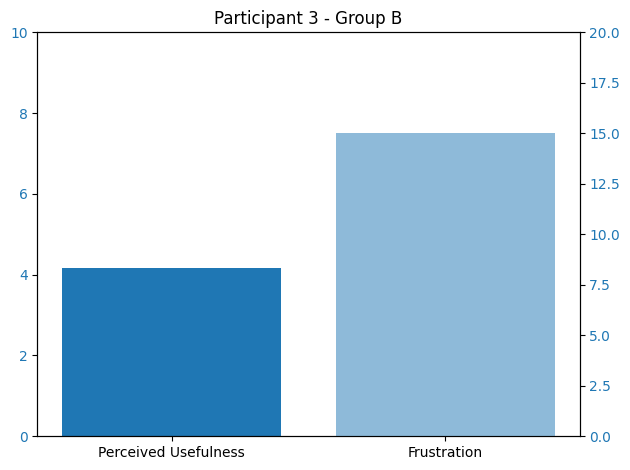

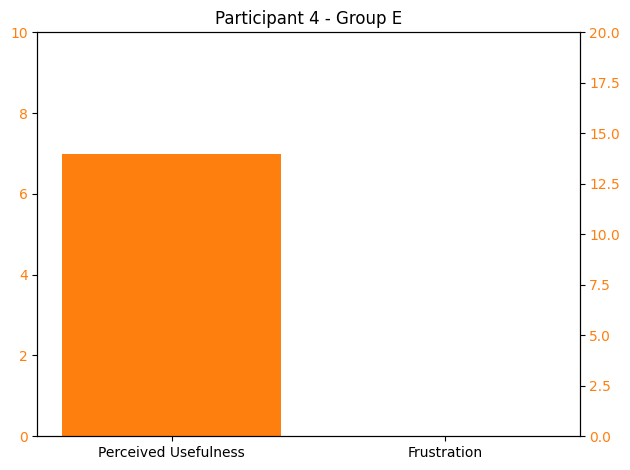

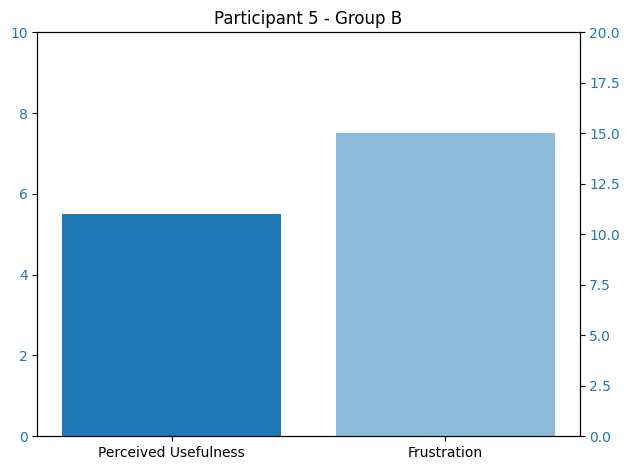

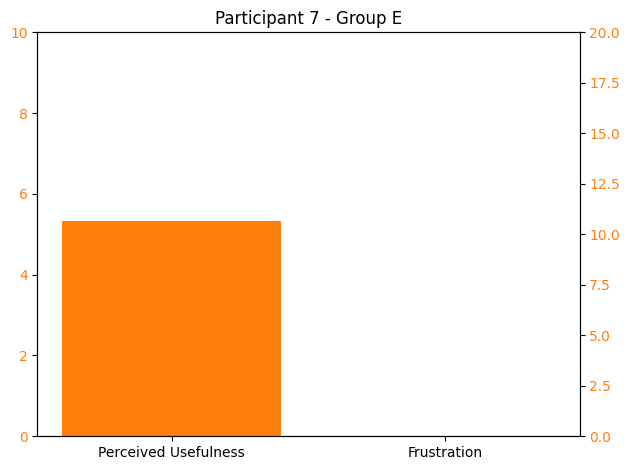

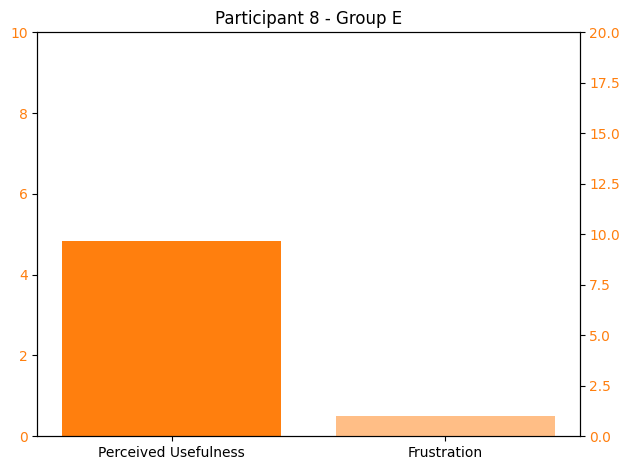

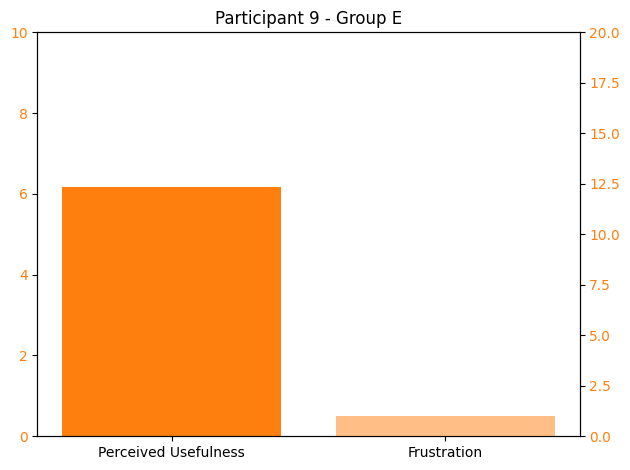

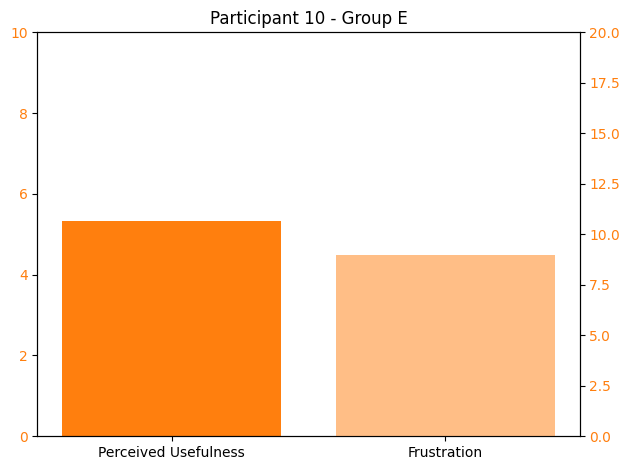

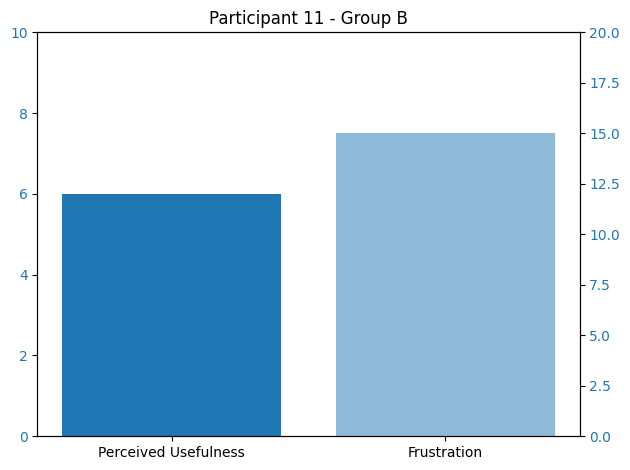

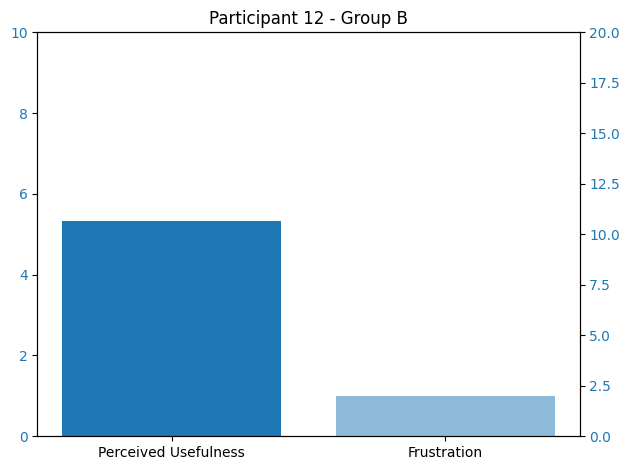

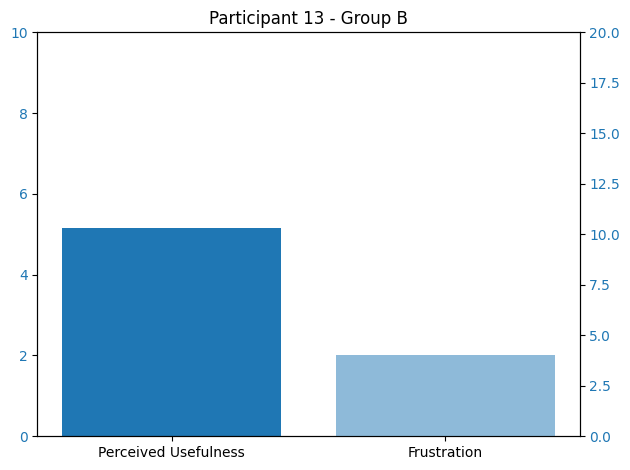

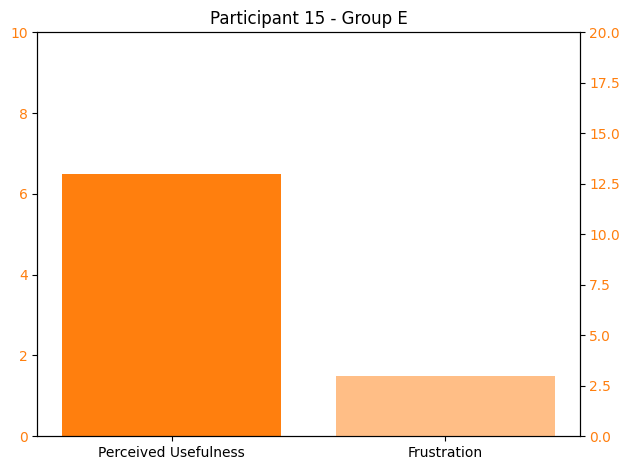

In [17]:
os.makedirs("./out/images/participants", exist_ok=True)

for idx, row in results_df.iterrows():
    scores = row[constructs].values

    scores_left = [row[c] for c in constructs_left]
    scores_right = [row[c] for c in constructs_right]

    fig, ax1 = plt.subplots()

    # Left y-axis for TAM and CSE constructs
    ax1.bar(constructs_left, scores_left, color=group_colors[row["Group"]])
    # ax1.set_ylabel("Score Perceived Usefulness", color=group_colors[row["Group"]])
    # ax1.set_ylabel("Score (TAM, CSE)", color=group_colors[row["Group"]])
    ax1.tick_params(axis="y", labelcolor=group_colors[row["Group"]])
    ax1.set_ylim(0, 10)

    # Right y-axis for NASA TLX constructs
    ax2 = ax1.twinx()
    ax2.bar(constructs_right, scores_right, color=group_colors[row["Group"]], alpha=0.5)
    # ax2.set_ylabel("Score Frustration", color=group_colors[row["Group"]])
    # ax2.set_ylabel("Score (NASA-TLX)", color=group_colors[row["Group"]])
    ax2.tick_params(axis="y", labelcolor=group_colors[row["Group"]])
    ax2.set_ylim(0, 20)

    # plt.title(f"Participant {idx} ({row['UUID']}) - Group {row['Group']}")
    plt.title(f"Participant {idx} - Group {row['Group']}")
    plt.tight_layout()
    plt.xticks(rotation=30)
    plt.savefig(f"./out/images/participants/participant_{idx}_scores.png")
    plt.show()